## Anomaly detection (unsupervised learning)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Load and check the data

In [2]:
# Load the dataset
X_train = np.load("data/X_part1.npy") # Training dataset
X_val = np.load("data/X_val_part1.npy") # Cross validation dataset
y_val = np.load("data/y_val_part1.npy") # Cross validation dataset (1: anomaly, 0: normal)

# Check shapes and a sample of each
print(X_train.shape, X_val.shape, y_val.shape)
print(X_train[0], X_val[0], y_val[0])

(307, 2) (307, 2) (307,)
[13.04681517 14.74115241] [15.79025979 14.9210243 ] 0


### Visualize data

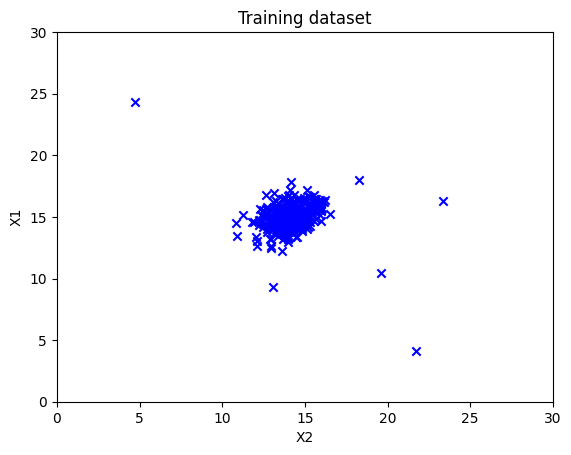

In [3]:
# Scatter plot data
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b') 

# Set the title
plt.title("Training dataset")
# Set the y-axis label
plt.ylabel('X1')
# Set the x-axis label
plt.xlabel('X2')
# Set axis range
plt.axis([0, 30, 0, 30])
plt.show()

### The gaussian distribution: Univariate VS Multi-variate

- The univariate Gaussian distribution is as follows:

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ controls the variance.

- However this example has 2 features per data point, hence the use of the multivariate gaussian distribution which has a different formula

$$ \phi(\textbf{x})=\left(\frac{1}{2\pi}\right)^{p/2}|\Sigma|^{-1/2}\exp\{-\frac{1}{2}(\textbf{x}-\mathbf{\mu})'\Sigma^{-1}(\textbf{x}-\mathbf{\mu})\}$$
   

### Functions

In [4]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """
    # Mean (sum(x)/m)
    mu = np.mean(X, axis=0)
    # Variance ((sum(x-mu)^2)/m)
    var = np.var(X, axis=0)
        
    return mu, var

def multivariate_gaussian(X, mu, var):
    """
    Computes the probability 
    density function of the examples X under the multivariate gaussian 
    distribution with parameters mu and var. If var is a matrix, it is
    treated as the covariance matrix. If var is a vector, it is treated
    as the var values of the variances in each dimension (a diagonal
    covariance matrix
    """
    
    k = len(mu)
    
    if var.ndim == 1:
        var = np.diag(var)
        
    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    
    return p

# Find probability threshold (epsilon) based on labeled cross validation data set
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on cross validation set
        p_val (ndarray): Results (gaussian probability) on cross validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
        # Count of predicted positives (both true and false positives)
        predicted_p = (p_val[p_val<epsilon]).shape[0]
        # Count of actual positives (or true positives+false negatives)
        actual_p = (y_val[y_val == 1]).shape[0]
        # Count of true positives
        true_p = p_val[(p_val<epsilon) & (y_val == 1)].shape[0]
        
        if predicted_p > 0:
            # Precision
            P = true_p/predicted_p
            # Recall
            R = true_p/actual_p
            # F1 score
            F1 = 2*P*R/(P+R)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

# Visualize into a contour plot
def visualize_fit(X, mu, var):
    """
    This visualization shows you the 
    probability density function of the Gaussian distribution. Each example
    has a location (x1, x2) that depends on its feature values.
    """
    
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'bx')

    if np.sum(np.isinf(Z)) == 0:
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), linewidths=1)
        
    # Set the title
    plt.title("The Gaussian contours of the distribution fit to the dataset")
    # Set the y-axis label
    plt.ylabel('Throughput (mb/s)')
    # Set the x-axis label
    plt.xlabel('Latency (ms)')

### Main flow
- calculate mean and variance
- calculate gaussian probabilities of training data based on the above
- Find anomaly threshold (low probabilities) based on labelled cross validation dataset
  - uses precision, recall and F1 score as decisison criteria
- Find outliers based on that threshold

In [5]:
# Estimate mean and variance of each feature
mu, var = estimate_gaussian(X_train)              

print("Mean of each feature:", mu)
print("Variance of each feature:", var)
    
# Calculate probabilities over training data based on mu and var
p = multivariate_gaussian(X_train, mu, var)

# Values with low probabilities are anomalies
# Need to decide the threshold (epsilon) for the low probabilities
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

# Find the outliers in the training set
# Returns an array with the same size with True or False values
outliers = p < epsilon
# Alternatively, the below returns indices of outliers
# outliers = np.where(p < epsilon)

Mean of each feature: [14.11222578 14.99771051]
Variance of each feature: [1.83263141 1.70974533]
Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000


### Visualize data with outliers

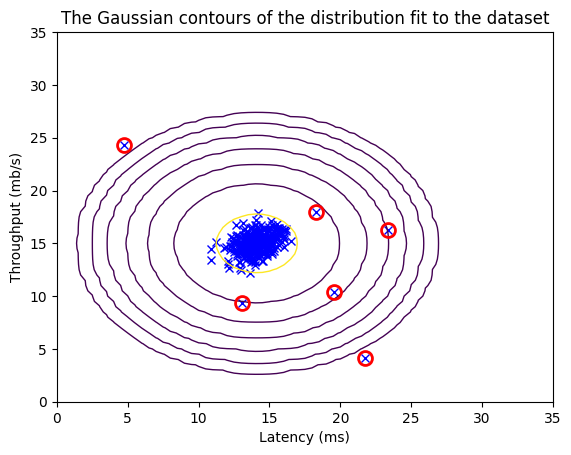

In [6]:
# Visualize the fit
visualize_fit(X_train, mu, var)

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)